## Detecting and analyzing incorrect model predictions with SageMaker Model Monitor and Debugger

### Install dependencies

Execute the following code cell to install dependencies and then restart the kernel:

In [ ]:
! pip install imageio opencv-python smdebug torchvision
! git clone https://github.com/advboxes/AdvBox advbox
! cd advbox; python setup.py build; python setup.py install
! pip install future

Test if module can be imported. If there is an error, try restarting your kernel.

In [ ]:
%load_ext autoreload
%autoreload 2
import advbox



### Archive model files and upload to Amazon S3

This notebook showcases a ResNet18 model that has been trained on the [German Traffic Sign dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) which consist of 43 classes.  Before the model can be deployed on SageMaker, its weights have to be archived and uploaded to Amazon S3:

In [ ]:
import tarfile

with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('model', recursive=True)

In [ ]:
import sagemaker
import boto3

boto_session = boto3.Session()
sagemaker_session = sagemaker.Session(boto_session=boto_session)

inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Define PyTorch model and deployment script

We use [SageMaker hosting services](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) to set up a persistent endpoint to get predictions from our model. Therefore, we define a PyTorch model object, that takes the S3 path of the model archive. We define an entry_point file [pretrained_model.py](https://github.com/aws-samples/amazon-sagemaker-analyze-model-predictions/blob/master/code/pretrained_model.py) that implements the [model_fn](https://github.com/aws-samples/amazon-sagemaker-analyze-model-predictions/blob/master/code/pretrained_model.py#L12) and [transform_fn](https://github.com/aws-samples/amazon-sagemaker-analyze-model-predictions/blob/master/code/pretrained_model.py#L29) functions: those functions are used during hosting to ensure that the model is correctly loaded inside the inference container and that incoming requests are properly processed.

In [ ]:
from sagemaker.pytorch import PyTorchModel

role = sagemaker.get_execution_role()

sagemaker_model = PyTorchModel(
    model_data=f's3://{sagemaker_session.default_bucket()}/model/model.tar.gz',
    role=role,
    source_dir='code',
    entry_point='pretrained_model.py',
    framework_version = '1.3.1',
    py_version='py3',
)

Let's have a look at `pretrained_model.py`

In [ ]:
%pycat code/pretrained_model.py

### Setup SageMaker Model Monitor and deploy model

[SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) automatically monitors machine learning models in production, and alerts when it detects data quality issues. We capture the inputs and outputs of our endpoint and later on we create a monitoring schedule to let Model Monitor inspect the collected data and model predictions. The DataCaptureConfig  API specifies the fraction of inputs and outputs that Model Monitor stores in a destination Amazon S3 bucket. In this example the sampling percentage is set to 50%, which means every other inference request is captured. 

In [ ]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=50,
    destination_s3_uri=f's3://{sagemaker_session.default_bucket()}/endpoint/data_capture',
)

Now we are ready to deploy the endpoint on an `ml.m5.xlarge` instance:

In [ ]:
predictor = sagemaker_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config,
)

# Our endpoint returns JSON, rather than default expected numpy:
predictor.accept = 'application/json'
deserializer = sagemaker.predictor.json_deserializer

endpoint_name = predictor.endpoint

### Run inference with normal test data

Before running inference, we download the test images of [GTSRB](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset

In [ ]:
! wget -N https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
! unzip -oq GTSRB_Final_Test_Images.zip
! wget -N https://raw.githubusercontent.com/aditbiswas1/P2-traffic-sign-classifier/master/signnames.csv

Load the names for image classes:

In [ ]:
from pandas.io.parsers import read_csv

signnames = read_csv('signnames.csv').values[:, 1]

Now we invoke the endpoint with a payload that contains serialized input images . The endpoint calls [transform_fn](https://github.com/aws-samples/amazon-sagemaker-analyze-model-predictions/blob/master/code/pretrained_model.py#L29) function to pre-process the data before performing model inference. The endpoint returns the predicted classes of the image stream as a list of integers, encoded in a json string. 

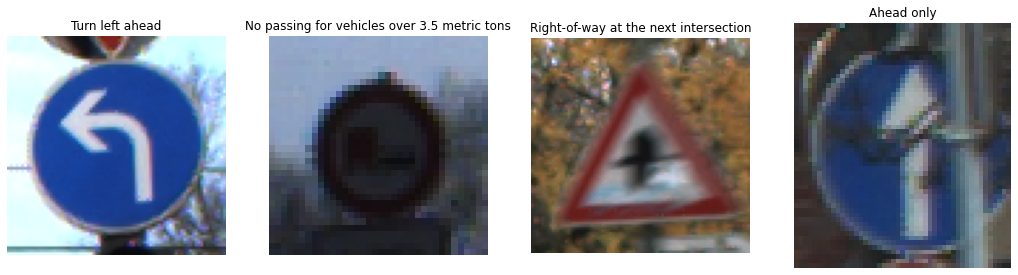

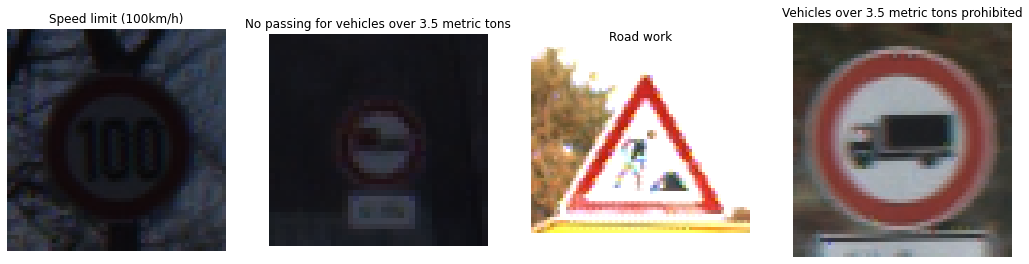

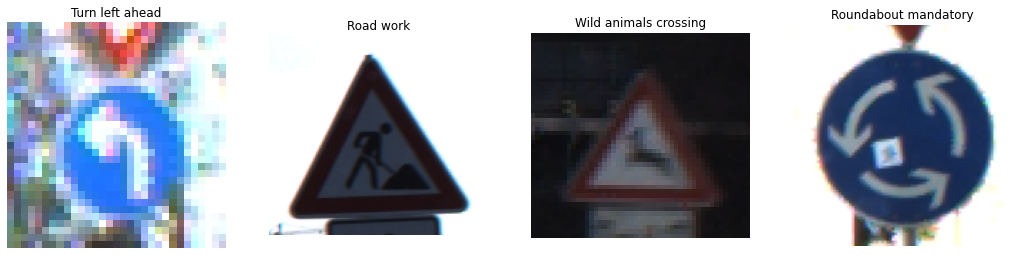

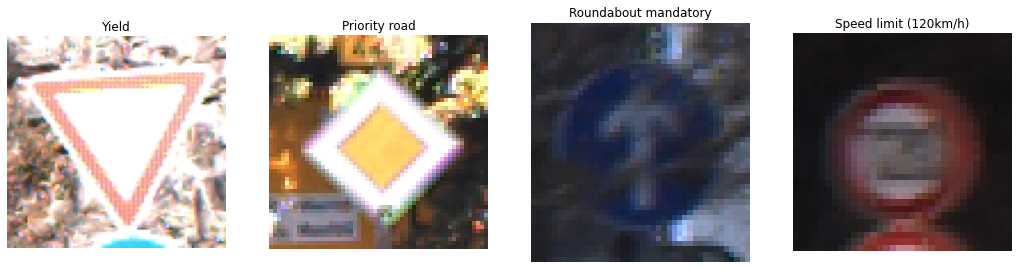

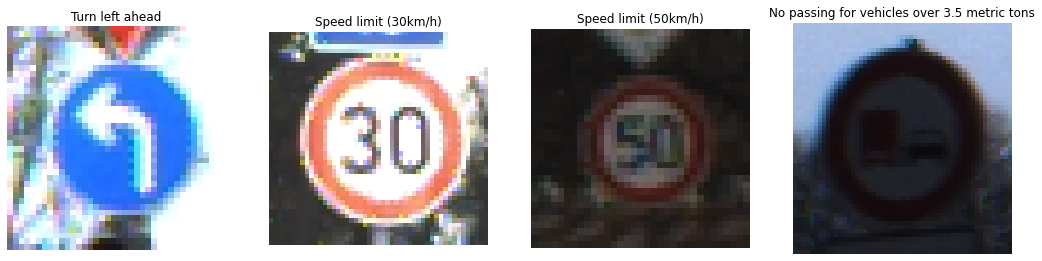

In [28]:
from PIL import Image
import glob
import matplotlib.pyplot as plt

ncols = 4  # Plot in multiple columns to save some space

for index, file in enumerate(glob.glob('GTSRB/Final_Test/Images/*ppm')):
    if index >= 20:
        break

    # Load image file to array:
    image = Image.open(file)

    # Invoke the endpoint: (Returns a 2D 1x1 array)
    result = predictor.predict(image)

    # Plot the results:
    ixcol = index % ncols
    if (ixcol == 0):
        plt.show()
        fig = plt.figure(figsize=(ncols*4.5, 4.5))
    plt.subplot(1, ncols, ixcol + 1)
    plt.title(signnames[result[0][0]])
    plt.imshow(image)
    plt.axis('off')

plt.show()

### Define a SageMaker Model Monitor schedule 


Next, we will describe how to configure the baseline and setup a monitoring schedule using SageMaker Model Monitor. Model Monitor provides a built-in container to create a [baseline](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-create-baseline.html) which calculates constraints and statistics such as mean, quantiles, and standard deviation. We can then launch a [monitoring schedule](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html) that periodically kicks off a processing job to inspect collected data, to compare the data against the given constraints and to generate a violations report. 

In our case we create a custom container that only performs a simple model sanity check: it runs an [evaluation](https://github.com/aws-samples/amazon-sagemaker-analyze-model-predictions/blob/master/docker/evaluation.py) script that simply counts the predicted image classes. If the model predicts a particular street sign way more often than other classes or if confidence scores are consistently low, then it indicates an issue. The evaluation script raises an issue if a particular image class is predicted more than 50% of the time.

First we need to create a custom container. The [dockerfile](docker/Dockerfile) takes the [evaluation script](docker/evaluation.py) as entrypoint file. The following code cell will build the Docker container and upload it to Amazon ECR. If you run this notebook inside Studio, then `docker build` won't work and you would have to run the command on an instance that provides `docker` command.

In [ ]:
import boto3

account_id = boto3.client('sts').get_caller_identity().get('Account')
ecr_repository = 'sagemaker-processing-container'
tag = ':latest'

region = boto3.session.Session().region_name

uri_suffix = 'amazonaws.com'
if region in ['cn-north-1', 'cn-northwest-1']:
    uri_suffix = 'amazonaws.com.cn'
processing_repository_uri = f'{account_id}.dkr.ecr.{region}.{uri_suffix}/{ecr_repository + tag}'

# Create ECR repository and push docker image
!docker build -t $ecr_repository docker
!$(aws ecr get-login --region $region --registry-ids $account_id --no-include-email)
!aws ecr create-repository --repository-name $ecr_repository
!docker tag {ecr_repository + tag} $processing_repository_uri
!docker push $processing_repository_uri

Now we define a SageMaker Model Monitor, where we indicate the location of the docker image and the environment variables that the evaluation script requires.

In [ ]:
from sagemaker.model_monitor import ModelMonitor

monitor = ModelMonitor(
    role=role,
    image_uri=processing_repository_uri,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    env={ 'THRESHOLD':'0.5' },
)

Next we define and attach a [Model Monitor Schedule](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-scheduling.html) to the endpoint. It will run our custom container on an hourly basis.

In [ ]:
from sagemaker.model_monitor import CronExpressionGenerator, MonitoringOutput
from sagemaker.processing import ProcessingInput, ProcessingOutput

destination = f's3://{sagemaker_session.default_bucket()}/endpoint/monitoring_schedule'
processing_output = ProcessingOutput(
    output_name='model_outputs',
    source='/opt/ml/processing/outputs',
    destination=destination,
)
output = MonitoringOutput(source=processing_output.source, destination=processing_output.destination)

monitor.create_monitoring_schedule(
    output=output,
    endpoint_input=predictor.endpoint,
    schedule_cron_expression=CronExpressionGenerator.hourly()
)

Let's have a look on the monitoring schedule

In [ ]:
monitor.describe_schedule()

SageMaker Model Monitor will run our processing job every hour. We can list the executions of those processing jobs:

In [ ]:
jobs = monitor.list_executions()
jobs

We can access the details of the processing job:

In [ ]:
if len(jobs) > 0:
    print(monitor.list_executions()[-1].describe())
else:
    print("""No processing job has been executed yet. 
    This means that one hour has not passed yet. 
    You can go to the next code cell and run the processing job manually""")

### Run processing job

Instead of waiting for an hour, we can manually start the processing job to already get some analysis results. Therefore we define a Processor object that takes the image URI of our custom image. We need to define the processing inputs which is the S3 bucket where inference request and outputs are stored.

In [ ]:
from sagemaker.processing import Processor

processor = Processor(
    role=role,
    image_uri=processing_repository_uri,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    env={ 'THRESHOLD':'0.5' },
)
    
processor.run(
    [ProcessingInput(
        input_name='data',
        source=f's3://{sagemaker_session.default_bucket()}/endpoint/data_capture',
        destination='/opt/ml/processing/input/endpoint/',
    )],
    [ProcessingOutput(
        output_name='model_outputs',
        source='/opt/ml/processing/outputs',
        destination=destination,
    )],
)

### Capture unexpected model behavior

In [ ]:
! mkdir adversarial_examples

Now that the schedule is defined, we are ready to monitor the model in real-time. To verify that the setup can capture unexpected behavior, we enforce false predictions. To achieve this we use [AdvBox Toolkit](https://github.com/advboxes/AdvBox), that introduces perturbations at the pixel level (also known as adversarial attacks) such that the model will not recognize correct classes any longer. We convert some test images such that they are now recognized as Stop signs.

In [ ]:
import utils
from advbox.adversarialbox.adversary import Adversary
from advbox.adversarialbox.attacks.deepfool import DeepFoolAttack
from advbox.adversarialbox.models.pytorch import PytorchModel

model = utils.load_model()

m = PytorchModel(model, None, (-3, 3), channel_axis=1)

attack = DeepFoolAttack(m)
attack_config = { 'iterations': 100, 'overshoot': 0.02 }

dataloader = utils.get_dataloader()

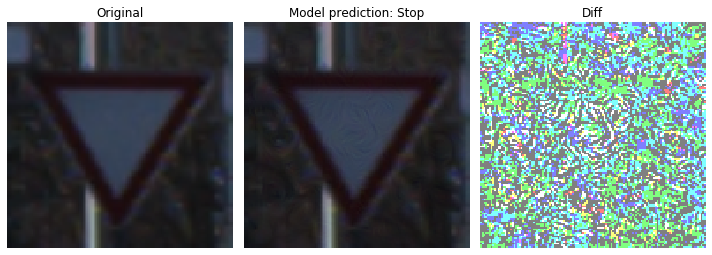

In [40]:
import numpy as np

for index, (inputs, labels) in enumerate(dataloader):

    adversary = Adversary(inputs.cpu().numpy(), None)

    tlabel = 14 #class label for stop sign
    adversary.set_target(is_targeted_attack=True, target_label=tlabel)

    adversary = attack(adversary, **attack_config)

    if adversary.is_successful():

        adv=adversary.adversarial_example[0]

        utils.show_images_diff(inputs, adv, adversary.adversarial_label, signnames, index)

        if index == 100:
            break

Send adversarial images to the endpoint:

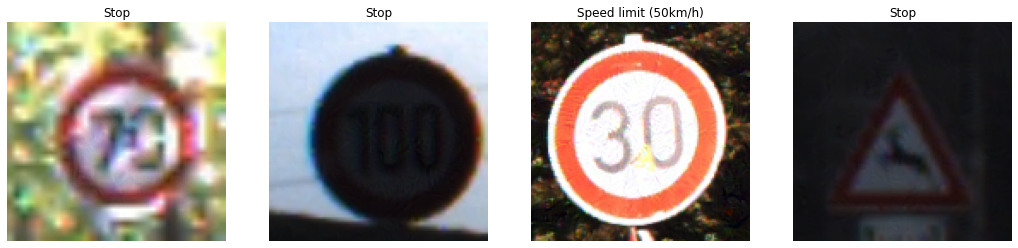

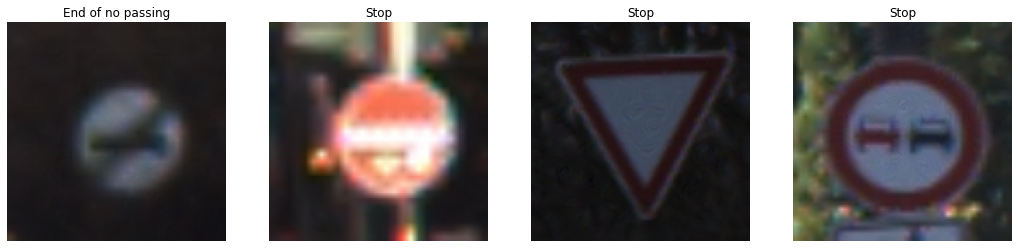

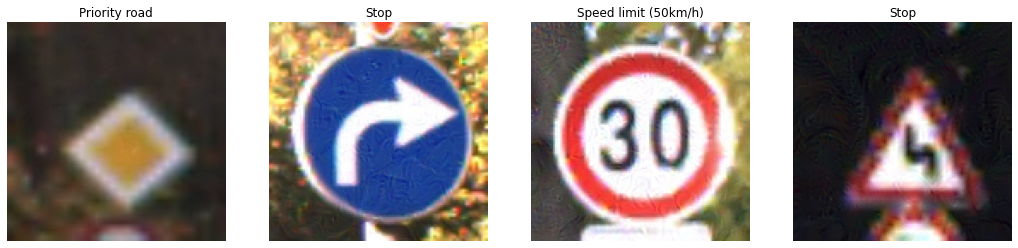

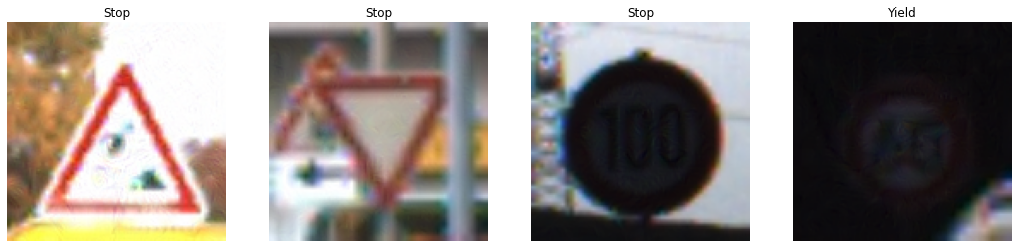

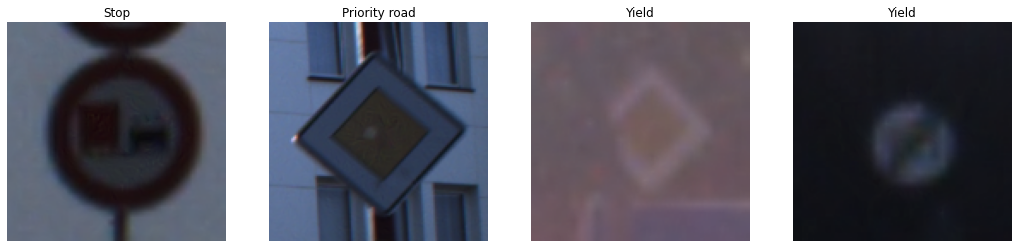

In [29]:
ncols = 4

for index, file in enumerate(glob.glob('adversarial_examples/*png')):
    # Load image file to array:
    image = Image.open(file)

    # Invoke the endpoint: (Returns a 2D 1x1 array)
    result = predictor.predict(image)

    # Plot the results:
    ixcol = index % ncols
    if (ixcol == 0):
        plt.show()
        fig = plt.figure(figsize=(ncols*4.5, 4.5))
    plt.subplot(1, ncols, ixcol + 1)
    plt.title(signnames[result[0][0]])
    plt.imshow(image)
    plt.axis('off')

plt.show()


When SageMaker Model Monitor schedules the next processing job, it will analyze the predictions that were captured and stored in Amazon S3. As described previously the processing job just performs a simple sanity check: it will simply count predicted image classes and if one class is predicted more than 50% of the time, an issue is raised. Since we sent advserial images to the endpoint,  we will now see an abnormal count for the image class 14 (‘Stop sign’). We can track the status of the job in SageMaker Studio and we can see that it found an issue:

![](images/screenshot.png)

We can get some further details from the CloudWatch logs: The processing job prints a dictionary where the key is one of 43 image classes and the value is the count. For instance in the following output cell we see that the endpoint predicted only twice the image class 9 and an abnormal count for class 14: it predicted this class 322 times which is higher than the threshold of 50%.
```
Warning: Class 14 ('Stop sign') predicted more than 80 % of the time which is above the threshold
Predicted classes {9: 2, 19: 1, 25: 1, 14: 322, 13: 5, 5: 1, 8: 10, 18: 1, 31: 4, 26: 8, 33: 4, 36: 4, 29: 20, 12: 8, 22: 4, 6: 4}

```

The values of the dictionary are also stored as CloudWatch metrics, so you can create graphs of the metric data using the CloudWatch console.

### Run processing job

SageMaker Model Monitor will run our processing job every hour. Like before we run the processing job once manually.

In [ ]:
processor.run(
    [ProcessingInput(
        input_name='data',
        source=f's3://{sagemaker_session.default_bucket()}/endpoint/data_capture',
        destination='/opt/ml/processing/input/endpoint/',
    )],
    [ProcessingOutput(
        output_name='model_outputs',
        source='/opt/ml/processing/outputs',
        destination=destination
    )],
)

### Update endpoint to enable SageMaker Debugger hook 

Once the processing job detected an issue it is time to get more insight into the model. Therefore we modify the inference function in the endpoint to emit tensors from the model. 

In [ ]:
sagemaker_model = PyTorchModel(
    model_data=f's3://{sagemaker_session.default_bucket()}/model/model.tar.gz',
    role=role,
    source_dir='code',
    entry_point='pretrained_model_with_debugger_hook.py',
    framework_version='1.3.1',
    py_version='py3',
)

Let's have a look at the inference function:

In [ ]:
%pycat code/pretrained_model_with_debugger_hook.py

We create a [SageMaker Debugger hook configuration](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/api.md#hook) in  model_fn, that takes a regular expression include_regex  indicating the names of the tensors to be emitted. The tensors will be stored in in our SageMaker default bucket under `endpoint/tensors`

Next we update the existing endpoint, that replaces the old entry_point file with the new one:

In [ ]:
predictor = sagemaker_model.deploy(
    instance_type='ml.m5.xlarge',
    initial_instance_count=1,
    endpoint_name=endpoint_name,
    update_endpoint=True,
    data_capture_config=data_capture_config,
)

# Our endpoint returns JSON, rather than default expected numpy:
predictor.accept = 'application/json'
deserializer = sagemaker.predictor.json_deserializer

Now whenever an inference request is made, tensors are recorded and uploaded to Amazon S3. So let's send some more adversarial images:

In [ ]:
ncols = 4

for index, file in enumerate(glob.glob('adversarial_examples/*png')):
    # Load image file to array:
    image = Image.open(file)

    # Invoke the endpoint: (Returns a 2D 1x1 array)
    result = predictor.predict(image)

    # Plot the results:
    ixcol = index % ncols
    if (ixcol == 0):
        plt.show()
        fig = plt.figure(figsize=(ncols*4.5, 4.5))
    plt.subplot(1, ncols, ixcol + 1)
    plt.title(signnames[result[0][0]])
    plt.imshow(image)
    plt.axis('off')

plt.show()

We can now compute saliency to get visual explanations from the model. 

### Analyse predictions with SageMaker Debugger

We have configured the SageMaker Debugger  hook to capture the relevant tensors. Now that the endpoint has been updated and tensors are uploading, we can [create a trial](https://github.com/awslabs/sagemaker-debugger/blob/master/docs/analysis.md#creating-a-trial-object) and read the data from Amazon S3.

In [ ]:
from smdebug.trials import create_trial

trial = create_trial(f's3://{sagemaker_session.default_bucket()}/endpoint/tensors')

Now we can compute the saliency maps. The method described in [Full-Gradient Representation for Neural Network Visualization [1]](https://arxiv.org/abs/1905.00780) requires all intermediate features and their biases. The following cell retrieves the gradients for the outputs of batchnorm and downsampling layers and the corresponding biases. If you use a model other than ResNet you may need to adjust the regular expressions in the following cell:

In [ ]:
biases, gradients = [], []

for tname in trial.tensor_names(regex='.*gradient.*bn.*output|.*gradient.*downsample.1.*output'):
    gradients.append(tname)
    
for tname in trial.tensor_names(regex='^(?=.*bias)(?:(?!fc).)*$'):
    biases.append(tname)

In the case of BatchNorm layers, we need to compute the implicit biases. In the following code cell we retrieve the necessary tensors:

In [ ]:
bn_weights, running_vars, running_means = [], [], []

for tname in trial.tensor_names(regex='.*running_mean'):
    running_means.append(tname)
    
for tname in trial.tensor_names(regex='.*running_var'):
    running_vars.append(tname)

for tname in trial.tensor_names(regex='.*bn.*weight|.*downsample.1.*weight'):
    bn_weights.append(tname) 

A helper function to normalize results:


In [ ]:
import numpy as np

def normalize(tensor):
    tensor = tensor - np.min(tensor)
    tensor = tensor / np.max(tensor)
    return tensor

The running averages in BatchNorm layers introduce an implicit bias that needs to be taken into account when computing the overall bias.

In [ ]:
def compute_implicit_biases(bn_weights, running_vars, running_means, step):
    implicit_biases = []
    for weight_name, running_var_name, running_mean_name in zip(bn_weights, running_vars, running_means):
        weight = trial.tensor(weight_name).value(step_num=step, mode=modes.PREDICT)
        running_var = trial.tensor(running_var_name).value(step_num=step, mode=modes.PREDICT)
        running_mean = trial.tensor(running_mean_name).value(step_num=step, mode=modes.PREDICT)
        implicit_biases.append(- running_mean / np.sqrt(running_var) * weight)
    return implicit_biases

Following code cell fetches all tensors and computes saliency map per image. Red pixels indicate the most relevant and blue pixels the least relevant pixel for predicting the image class. 

Predicted class: 14


<Figure size 432x288 with 0 Axes>

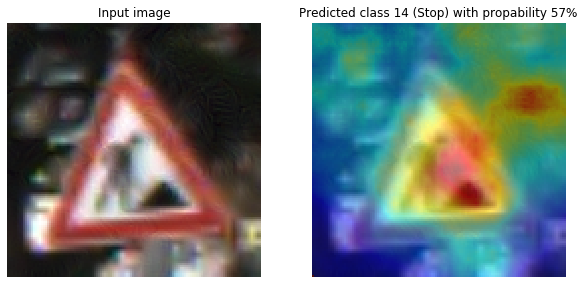

In [39]:
from smdebug import modes
from smdebug.core.modes import ModeKeys
import cv2
import scipy.ndimage
import scipy.special
import utils

for step in trial.steps():

    image_batch = trial.tensor("ResNet_input_0").value(step_num=step, mode=modes.PREDICT)

    #compute implicit biases from batchnorm layers
    implicit_biases = compute_implicit_biases(bn_weights, running_vars, running_means, step)

    for item in range(image_batch.shape[0]):

        #input image
        image = image_batch[item,:,:,:]

        #get gradients of input image
        image_gradient = trial.tensor("gradient/image").value(step_num=step, mode=modes.PREDICT)[item,:]  
        image_gradient = np.sum(normalize(np.abs(image_gradient * image)), axis=0)
        saliency_map = image_gradient

        for gradient_name, bias_name, implicit_bias in zip(gradients, biases, implicit_biases):

            #get gradients and bias vectors for corresponding step
            gradient = trial.tensor(gradient_name).value(step_num=step, mode=modes.PREDICT)[item:item+1,:,:,:]
            bias = trial.tensor(bias_name).value(step_num=step, mode=modes.PREDICT) 
            bias = bias + implicit_bias

            #compute full gradient
            bias = bias.reshape((1,bias.shape[0],1,1))
            bias = np.broadcast_to(bias, gradient.shape)
            bias_gradient = normalize(np.abs(bias * gradient))

            #interpolate to original image size
            for channel in range(bias_gradient.shape[1]):
                interpolated = scipy.ndimage.zoom(bias_gradient[0,channel,:,:], 128/bias_gradient.shape[2], order=1)
                saliency_map += interpolated 


        #normalize
        saliency_map = normalize(saliency_map) 

        #predicted class and propability
        predicted_class = trial.tensor("fc_output_0").value(step_num=step, mode=modes.PREDICT)[item,:]
        print("Predicted class:", np.argmax(predicted_class))
        scores = np.exp(np.asarray(predicted_class))
        scores = scores / scores.sum(0)
        
        #plot image and heatmap
        utils.plot_saliency_map(saliency_map, image, np.argmax(predicted_class), str(int(np.max(scores) * 100)), signnames )
    

### Cleanup

In [ ]:
monitor.delete_monitoring_schedule()

In [ ]:
predictor.delete_endpoint()